[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JorisRoels/deep-learning-biology/blob/main/exercises/solutions/2020-dlb-0-intro-pytorch-solution.ipynb)

# Exercise 0: Introduction to PyTorch

All of the practical sessions will be largely based on [PyTorch](https://pytorch.org/), a high-level deep learning library. PyTorch is a well-known, open-source, machine learning framework that has a comprehensive set of tools and libraries and accelerates research prototyping. It also supports transparant training of machine learning models on GPU devices, which can benefit runtimes significantly. The full documentation can be found [here](https://pytorch.org/docs/stable/index.html). In this notebook, we will be getting familiar with PyTorch, a popular deep learning library. 

The structure of these exercises is as follows: 

0. [Installation (optional)](#scrollTo=ScagUEMTMjlK)
1. [Import libraries](#scrollTo=ScagUEMTMjlK)
2. [Data in Pytorch: Tensors](#scrollTo=ohZHyOTnI35b)
3. [Datasets and dataloaders](#scrollTo=kIry8iFZI35y)
4. [Computational models](#scrollTo=uXrEb0rTI35-)

This notebook is largely based on the [PyTorch tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html). 

## 0. Installation (optional)
For these exercise sessions, you can either choose to work locally on your own laptop, or remote in Google Colab. This section is required for those who would like to work locally. 

To get started with the exercise sessions, your environment should satisfy the following prerequisites: 
1. Check whether you have a [CUDA enabled GPU]. If not, you will have to work on the CPU, which will be significantly slower. we highly suggest to use Google Colab for these sessions in that case. 
2. Python 3.6 or higher ([install](https://www.python.org/)) - version check: `python --version`
3. A package manager: Anaconda [install](https://www.anaconda.com/) or pip [install](https://pypi.org/project/pip/) - pip comes along with the suggested installer from the previous step. In that case you can skip this step. 
3. CUDA ([install](https://developer.nvidia.com/cuda-zone)) - version check: `nvcc --version`
4. PyTorch ([install](https://pytorch.org/)) - select your OS, package manager and compute platform (CUDA version) and run the suggested command. 
5. To ensure a correct installation, you should be able to run the following cell without errors. 

In [1]:
import torch
print(f'Succesfully loaded the PyTorch module! ')
print(f'CUDA available? {torch.cuda.is_available()}')

Succesfully loaded the PyTorch module! 
CUDA available? True


You are now ready to do the exercises locally! 

## 1. Import libraries
Let's start with importing the necessary libraries. 

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
plt.rcdefaults()
%matplotlib notebook
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets

As you will notice, Colab environments come with quite a large library pre-installed. If you need to import a module that is not yet specified, you can add it in the previous cell (make sure to run it again). If the module is not installed, you can install it with `pip`. 

To make your work reproducible, it is advised to initialize all modules with stochastic functionality with a fixed seed. Re-running this script should give the same results as long as the seed is fixed. 

In [3]:
# make sure the results are reproducible
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

To be able to perform calculations in parallel, you will need a decent GPU device. Let's find out which devices are available in this environment. PyTorch can help you with this. 

**Exercise**: 
- Find out which devices are available using the functions available in the [`torch.cuda`](https://pytorch.org/docs/stable/cuda.html) module. 

In [4]:
# get the amount of available devices
n_devices = torch.cuda.device_count()
print(f'Number of available devices: {n_devices}')

# get stats of each available device
for i in range(n_devices):
    device = torch.cuda.device(i)
    print(torch.cuda.get_device_properties(device))

# select the first GPU as our target device
device = 0

Number of available devices: 1
_CudaDeviceProperties(name='Quadro P2000', major=6, minor=1, total_memory=4042MB, multi_processor_count=6)


Depending on your hardware configuration, you will see the available devices. In Google Colab, you should have at least one GPU available. If not, go to "Runtime > Change runtime type" and make sure that GPU is selected as hardware accelerator (adjustments will require a session restart). 

You are now ready to do some calculations using the selected GPU device in PyTorch. 

## 2. Data in PyTorch: Tensors

When you think about representing data in Python, you will probably think about numpy arrays (i.e. `ndarray` objects) and the many useful operations that can be performed with these data structures. Unfortunately, numpy does not allow computations on accelerated devices such as GPUs. PyTorch aims to resolve this issue, while also being fully compatible with numpy. Instead of `ndarray` objects, PyTorch uses `Tensor` objects, which are basically multidimensional arrays.  

Let's have a look at an example. In the code snippet below, we implement a dot product between two vectors in numpy. 

In [5]:
# initialize the two vectors
a = np.array([1., 2., 3., 4.])
b = np.array([5., 6., 7., 8.])
print(a)
print(b)

# compute the dot product
dot = np.dot(a, b)
print(dot)

[1. 2. 3. 4.]
[5. 6. 7. 8.]
70.0


In PyTorch we can do this using a very similar syntax. 

In [6]:
# initialize the two vectors
a = torch.tensor([1., 2., 3., 4.])
b = torch.tensor([5., 6., 7., 8.])
print(a)
print(b)

# compute the dot product
dot = torch.dot(a, b)
print(dot)

tensor([1., 2., 3., 4.])
tensor([5., 6., 7., 8.])
tensor(70.)


To port the numpy code to PyTorch, you basically have to change `np.array` into `torch.tensor` and `np` into `torch`. Note this will definitely not always be the case as there are still some differences in the interface. 

However, now we can run the PyTorch code on the GPU by simply calling the `to` method of the Tensor class with the device index that we selected just before. 

In [7]:
# initialize the two vectors
a = torch.tensor([1., 2., 3., 4.]).to(device)
b = torch.tensor([5., 6., 7., 8.]).to(device)
print(a)
print(b)

# compute the dot product
dot = torch.dot(a, b)
print(dot)

tensor([1., 2., 3., 4.], device='cuda:0')
tensor([5., 6., 7., 8.], device='cuda:0')
tensor(70., device='cuda:0')


Very straightforward to perform calculations on the GPU! Note: if you want to run the computations in PyTorch on CPU, you can always set `device = 'cpu'`. Switching between tensors and numpy arrays is simple: 

In [8]:
# convert a tensor to a numpy array
a = a.to('cpu').numpy()
print(a.__class__)

# convert a numpy array to a tensor
a = torch.from_numpy(a)
print(a.__class__)

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


Keep in mind that you first have to transfer the tensor to the CPU before you convert it into a numpy array. 

You can initialize tensors in various ways: 

In [9]:
# desired shape of the tensor
shape = (2, 3)

# initialization
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.4963, 0.7682, 0.0885],
        [0.1320, 0.3074, 0.6341]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


Furthermore, tensors have various attributes that you can use. 

In [10]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


Now it's your time to experiment with PyTorch! 

**Exercise**: get familiar with the PyTorch documentation. 
- Implement the (numpy based) code below using PyTorch. 
- Transfer all tensors to a GPU device. 
- Wrap both the numpy and pytorch code within a for loop and measure the runtime over a number of repetitions (you can use the `time.time()` function). Experiment with the amount of repetitions and the size of the arrays/tensors. How do numpy and PyTorch compare? 

In [11]:
# perform various operations on these matrices
def numpy_ops(X, Y):
    W = np.matmul(X, Y)
    W = W - np.mean(X)
    W = W / np.std(Y)
    W = np.sqrt(np.abs(W))
    return W

# size of the matrix
n = 4

# randomly define two matrices
X = np.random.randn(n, n)
Y = np.random.randn(n, n)
W = numpy_ops(X, Y)
print(X)
print(Y)
print(W)

[[ 1.76405235  0.40015721  0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323  0.33367433]]
[[ 1.49407907 -0.20515826  0.3130677  -0.85409574]
 [-2.55298982  0.6536186   0.8644362  -0.74216502]
 [ 2.26975462 -1.45436567  0.04575852 -0.18718385]
 [ 1.53277921  1.46935877  0.15494743  0.37816252]]
[[2.35510072 0.96279603 0.72458616 1.23089613]
 [2.34427337 1.66235797 0.87174643 1.21904292]
 [0.76041767 1.14157238 0.30443694 0.54866829]
 [1.18786272 0.86776702 0.45769284 1.06947055]]


<IPython.core.display.Javascript object>


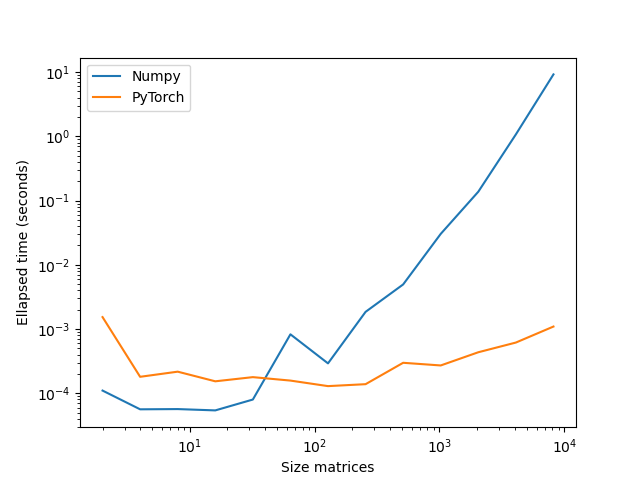

In [12]:
# perform various operations on these matrices
def torch_ops(X, Y):
    W = torch.matmul(X, Y)
    W = W - torch.mean(X)
    W = W / torch.std(Y)
    W = torch.sqrt(torch.abs(W))
    return W

# number of repetitions
reps = 1
# size of the matrices
ns = 2**np.arange(1, 14)

# run numpy code
numpy_times = np.zeros_like(ns, dtype=float)
for i, n in enumerate(ns):
    X = np.random.randn(n, n)
    Y = np.random.randn(n, n)
    t = time.time()
    for r in range(reps):
        W = numpy_ops(X, Y)
    numpy_times[i] = (time.time() - t)

# run pytorch code
torch_times = np.zeros_like(ns, dtype=float)
for i, n in enumerate(ns):
    X = torch.randn(n, n).to(device)
    Y = torch.randn(n, n).to(device)
    t = time.time()
    for r in range(reps):
        W = torch_ops(X, Y)
    torch_times[i] = (time.time() - t)
    
# visualize results
plt.plot(ns, numpy_times)
plt.plot(ns, torch_times)
plt.xscale('log')
plt.yscale('log')
plt.legend(('Numpy', 'PyTorch'))
plt.xlabel('Size matrices')
plt.ylabel('Ellapsed time (seconds)')
plt.show()

We can draw two main conclusions from these experiments: 
- The PyTorch implementation scales significantly better towards larger inputs due to the large amounts of operations that can be performed in parallel. GPUs are ideal for parallel computing, whereas classical CPUs are more suitable for sequential processing. 
- For smaller inputs, it can be that the numpy implementation outperforms PyTorch. This is largely due to the fact that memory transfers between the CPU and GPU cause too much overhead compared to the parallelism performance gain. Before deploying models on a GPU device, it is therefore crucial to have sufficiently large datasets. 

Now that we know how tensors are used in PyTorch, we are ready to work with actual data in so-called datasets and dataloaders. 

## 4. Datasets and dataloaders

Ideally, you would like to decouple data from your predictive model. This would allow you to easily try out a specific model on a different dataset (or another model on the same dataset). The data management part that enables this in PyTorch is handled by the `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes. `Dataset` stores the samples (and, optionally, their corresponding labels), and `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

Lots of commonly used datasets are available in PyTorch. Check out the [documentation](https://pytorch.org/vision/stable/datasets.html) for a full overview. For example, let's try and load the well-known MNIST dataset. 

In [13]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True
)

/home/jorisro/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


If you haven't downloaded this dataset yet in the specified root directory, this will download and extract it. Note that this dataset consists of a training and testing part. 

The `training_data` and `test_data` objects inherit from the `torch.utils.data.Dataset` and can be used for sampling through indexing, similar to lists. In other words, `training_data[i]` will return the `i`th training sample of the MNIST dataset, which is a tuple of an image of a digit and the corresponding label. The following code illustrates this principle and shows a few examples of the MNIST dataset. 

<IPython.core.display.Javascript object>


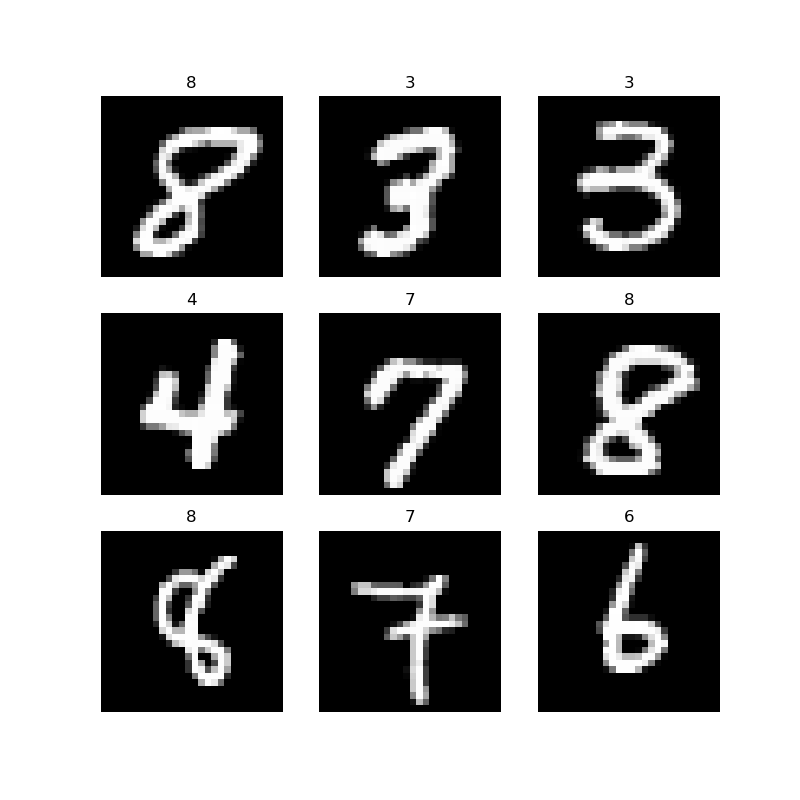

In [15]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

Let's have a closer look at these datasets by printing out all their variables. 

In [16]:
vars(training_data)

{'root': 'data',
 'transform': None,
 'target_transform': None,
 'transforms': None,
 'train': True,
 'data': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 

You can see that the data and corresponding target labels are stored in memory as tensors. 

It is more likely that you would like to try out PyTorch models on your own data, instead of public datasets such as MNIST. To do this, you simply have to define a new class that inherits from `torch.utils.data.Dataset` and implement three functions: 
- `__init__`: this is the initializer of the class and will be called whenever a new instance of the class is generated. Common tasks that are performed in this method include loading the data (if they fit in memory), data pre-processing, etc. 
- `__len__`: this function returns the length of the dataset. 
- `__getitem__`: this function takes an index `i` as argument and returns the `i`th sample. 

**Exercise**: implement your own dataset that contains randomly generated data and labels by filling in the following skeleton code. 

In [17]:
class CustomDataset(Dataset):
    
    def __init__(self, n_samples=100, n_classes=10, data_dim=20):
        self.data = np.random.randn(n_samples, data_dim)
        self.labels = np.random.randint(n_classes, size=(n_samples))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, i):
        return (self.data[i], self.labels[i])

data = CustomDataset(n_samples=100, n_classes=10, data_dim=20)
x, y = data[0]
print(x)
print(y)

[-0.71216714 -0.1070374  -1.25278353  1.49471473  2.68525716  1.21700408
  2.16136983 -1.35365079  0.73299317 -1.09428384 -0.27164224  0.50199799
  0.04181315 -1.35381196 -0.13851385  0.75170024 -0.69435849  0.87222505
  0.62612781  0.53762138]
5


Excellent! Now we are ready to define computational models in PyTorch! 

## 5. Computational models

PyTorch uses the so-called `torch.nn.Module` class to represent functions that take one or more inputs and generate one or more outputs. Neural networks, as we will see in the following sessions, also fall within this category. 

As an example, let's look at a simple function that takes a vector as input, multiplies it with a number and adds a number to the result. 

In [27]:
class LinearModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.m = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
    
    def forward(self, x): 
        return self.m*x + self.b

f = LinearModel()
x = torch.randn(1)
y = f(x)

print(f'm={float(f.m)}')
print(f'b={float(f.b)}')
print(f'x={float(x)}')
print(f'y={float(y)}')

m=0.06080929562449455
b=0.5427379608154297
x=0.986354649066925
y=0.6027175188064575


Whenever you implement a `Module`, you have to implement the `forward` function as a minimum. This function defines the so-called forward propagation, i.e. the calculations necessary to generate an output for a given input. By using a `Module` as a function on a specific input `x` (i.e. `f(x)`), its `forward function` will be called with that particular input as an argument. Optionally, you can also define an initializer, which will be called whenever you instantiate the Module. Typically, this is used to initialize all necessary parameters of the module. In fact, we can explicitely tell the module that these numbers are parameters by wrapping them in an `torch.nn.Parameter` object. This enables optimization of these values later on. 

You might wonder why we can't simply define the linear model as a function in Python, which would require much less lines of code. The answer is in the automatic differentiation that is implemented in PyTorch. Let's explain this through an example. 

Consider a least squares linear regression problem, i.e. we have samples $D = \{(x_i, y_i)\}_{i=1, \dots, n}$ that approximately follow a straight line. In other words: 
$$
y_i = m x_i + b + \varepsilon_i
$$
where $\varepsilon_i$ is a small noise perturbation. The following code generates such a dataset $D$ and visualizes it. 

<IPython.core.display.Javascript object>


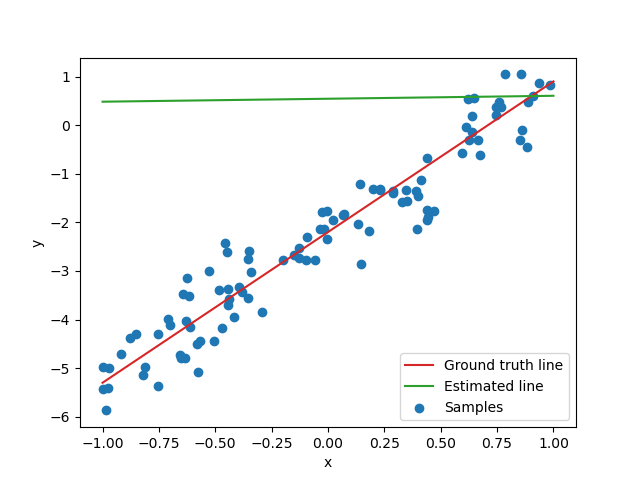

In [28]:
# data parameters
n = 100
sigma_noise = 0.5

# actual line parameters (y = m*x + b)
m_real = 3.1
b_real = -2.2

# random numbers uniformly distributed in [-1, 1]
x = 2*torch.rand(n) - 1
# noisy data along a straight line
y = m_real*x + b_real + sigma_noise*torch.randn(x.shape)

# show the data
def show_data(x, y, f=None):
    x_ = torch.tensor([-1, 1])
    plt.scatter(x, y, c='tab:blue')
    plt.xlabel('x')
    plt.ylabel('y')
    if f is not None:
        y_ = f(x_)
        plt.plot(x_, m_real*x_ + b_real, 'tab:red')
        plt.plot(x_, y_.detach(), 'tab:green')
        plt.legend(('Ground truth line', 'Estimated line', 'Samples'))
    else:
        plt.plot(x_, m_real*x_ + b_real, 'tab:red')
        plt.legend(('Ground truth line', 'Samples'))

fig = plt.figure()
show_data(x, y, f=f)

Our current linear model is definitely not a good fit for the data. A least squares estimator aims to optimize this linear model by minimizing the mean squared error (MSE) between the predictions $f(x_i)$ of our model $f$ and the actual output values $y_i$, i.e.
$$
\hat{f} = \arg\min_f \frac{1}{n} \sum_i (f(x_i) - y_i)^2
$$

This is relatively straightforward to implement in PyTorch. 

<IPython.core.display.Javascript object>


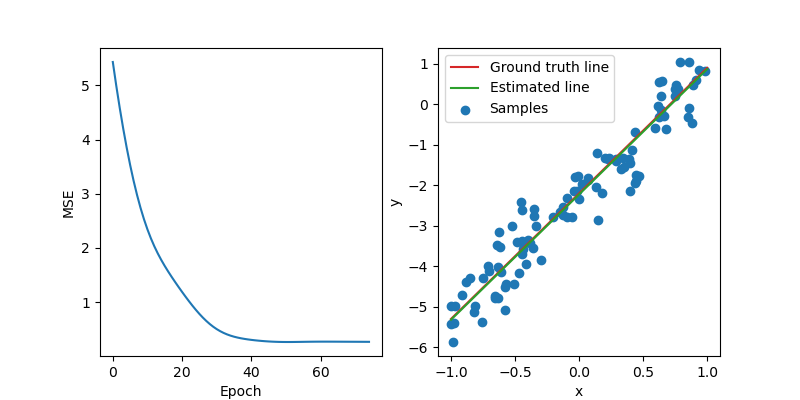

Estimated model parameters: y=3.093812942504883*x + -2.2257320880889893
Actual linear model: y=3.1*x + -2.2


In [29]:
# initialize a new model
f = LinearModel()

# optimization parameters
lr = 0.1
epochs = 75
mse_fn = nn.MSELoss()
optimizer = optim.Adam(f.parameters(), lr=lr)

# start optimization
epochs_rng = torch.arange(epochs)
mses = torch.zeros(epochs)
fig = plt.figure(figsize=(8, 4))
for epoch in range(epochs):
    
    # zero out the gradients
    optimizer.zero_grad()
    
    # current predictions
    y_pred = f(x)
    
    # compute error
    mse = mse_fn(y_pred, y)
    mses[epoch] = mse
    
    # backward propagation
    mse.backward()
    
    # adjust parameters (f.m and f.b)
    optimizer.step()

    # show error and regression throughout training
    plt.clf()
    plt.subplot(1, 2, 1)
    plt.plot(epochs_rng[:epoch+1], mses[:epoch+1].detach(), 'tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.subplot(1, 2, 2)
    show_data(x, y, f=f)
    plt.pause(0.01)
    fig.canvas.draw()

# print out results
print(f'Estimated model parameters: y={float(f.m)}*x + {float(f.b)}')
print(f'Actual linear model: y={m_real}*x + {b_real}')

That seems a reasonable regression! Now what is exactly going on here? 

The idea is that we try to minimize an error function (i.e. the MSE) on the data. The minimization algorithm is called gradient descent (we'll elaborate on this in the next theory session) and often used in optimization problems. 

The issue is that gradient descent requires computing the derivative of the loss function with respect to all parameters in the model, which can be mathematically tricky. Fortunately, PyTorch can do this automatically as long as we define the computations of our model within a `Module`. This automatic differentiation is often refered to as their [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) system. 

**Exercise**: implement a new `Module` that takes a vector as input, applies matrix multiplication, adds a vector to the result and finally applies a sigmoid function to each element. In other words: 
$$
f(x) = \sigma(Ax+b)
$$
where $\sigma(z) = \frac{1}{1+e^{-z}}$. 

In [21]:
class SimpleNet(nn.Module):
    
    def __init__(self, n, m):
        super().__init__()
        self.A = nn.Parameter(torch.randn(m, n))
        self.b = nn.Parameter(torch.randn(m))
    
    def forward(self, x): 
        return torch.sigmoid(torch.matmul(self.A, x) + self.b)

n = 10
m = 5
f = SimpleNet(n, m)
x = torch.randn(n)
y = f(x)

print(f'x={x}')
print(f'y={y}')

x=tensor([ 0.1621,  0.5361, -0.6766,  0.6861, -0.6193, -0.1140, -0.3004,  0.5409,
         0.5539,  0.1757])
y=tensor([0.4833, 0.8633, 0.1605, 0.7495, 0.5146], grad_fn=<SigmoidBackward>)


Congratulations! You have just implemented the forward propagation step of a neural network! Thanks to the autograd system in PyTorch, we don't have to worry about the backward propagation. In the next theory session, we will see what backpropagation exactly means and how we can train a neural network. 